# Testing methods for extracting CO2 fertilisation effect from OzFlux GPP


In [1]:
%matplotlib inline

import os
import sys
import pickle
import warnings
import scipy.stats
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from scipy.signal import detrend
from scipy.stats import theilslopes, kendalltau
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression

# sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src')

## Analysis Parameters

In [2]:
# base = '/g/data/xc0/project/AusEFlux/data/training_data/'
base = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/training_data/'
site = 'HowardSprings'# 'HowardSprings'  'Tumbarumba'
# variables = ['GPP_SOLO_EC','rain_RS','SRAD_RS','Tavg_RS','VPD_RS']
covar_file = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/covars.nc'

## Open data

and prepare it for the modelling.

In [3]:
covars = xr.open_dataset(covar_file).drop_vars(['wcf','smrz'])

#make sure flux tower doesn't extend beyond covars time range
df = pd.read_csv(f'{base}{site}.csv',index_col='time', parse_dates=True)
mask = (df.index > '2000-1-1') & (df.index <= '2022-12-31')
df = df.loc[mask]
df = df[['GPP_SOLO_EC', 'fPAR_RS', 'x_coord', 'y_coord']] #keep just the data we need.
df = df.rename({"GPP_SOLO_EC":'GPP', 'fPAR_RS':'fPAR'},axis=1)

# select nearest pixel to flux tower
time_start = str(np.datetime_as_string(df.index[0].to_numpy(), unit='D'))
time_end = str(np.datetime_as_string(df.index[-1].to_numpy(), unit='D'))

idx=dict(latitude=df.y_coord.iloc[0],longitude=df.x_coord.iloc[0])
covars = covars.sel(idx, method='nearest').sel(time=slice(time_start, time_end)) # grab pixel
covars = covars.reindex(time=df.index.to_numpy(), method='nearest', tolerance='1D').compute() 

#join covars onto flux data
df = df.join(covars.drop_vars('spatial_ref').to_dataframe())
df = df.drop(['x_coord', 'y_coord', 'latitude', 'longitude'], axis=1)
df.head(2)

,GPP,fPAR,co2,rain,srad,tavg,vpd,cwd
time,,,,,,,,
2002-01-15,225.192075,0.679929,368.704498,165.700165,21.548227,29.554178,13.386786,19.509516
2002-02-15,207.291315,0.718013,368.871002,554.129456,18.900572,28.069952,8.162815,0.000000


In [4]:
def filter_complete_years(dff):
    # Extract year and month information
    df = dff.reset_index(drop=False)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    
    # Identify years with all 12 months
    complete_years = (
        df.groupby('year')['month']
        .nunique()
        .loc[lambda x: x == 12]  # Keep only years with exactly 12 unique months
        .index
    )

    # Filter the data array to include only these complete years
    filtered_data = dff.loc[dff.index.year.isin(complete_years)]
    
    return filtered_data

#remove incomplete years
df = filter_complete_years(df)

rain = df['rain'].resample('YS').sum()
gpp = df['GPP'].resample('YS').sum()
fpar = df['fPAR'].resample('YS').sum()

df = df.drop(['GPP','rain', 'fPAR'],axis=1).resample('YS').mean()
df['rain'] = rain
df['GPP'] = gpp
df['fPAR'] = fpar

co2 =  xr.open_dataset(covar_file)['co2']
co2 = co2.mean(['latitude', 'longitude']).resample(time='YS').mean().drop_vars('spatial_ref').to_dataframe(name='co2')
df['co2'] = co2
df.head(2)

,co2,srad,tavg,vpd,cwd,rain,GPP,fPAR
time,,,,,,,,
2002-01-01,369.700684,22.045380,27.608353,19.561270,61.482433,1357.663940,1746.723167,6.31648
2003-01-01,371.994019,21.428429,27.838531,18.995981,55.051060,2082.156738,1667.035993,6.40442


## Testing implementing GPP residual method

Following [Zhan et al 2024](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023JG007910)



### Steps 1 and 2

In [5]:
model_var = 'GPP'

for v in [model_var,'rain','srad','tavg','vpd', 'cwd', 'co2']:
    df[f'{v}_detrend'] = detrend(df[v])
    df[f'{v}_detrend'] = df[f'{v}_detrend'] + df[v].median() # add back median

df.head(3)

,co2,srad,tavg,vpd,cwd,rain,GPP,fPAR,GPP_detrend,rain_detrend,srad_detrend,tavg_detrend,vpd_detrend,cwd_detrend,co2_detrend
time,,,,,,,,,,,,,,,
2002-01-01,369.700684,22.045380,27.608353,19.561270,61.482433,1357.663940,1746.723167,6.316480,2083.626004,1362.176758,22.166042,28.044992,20.002892,61.583996,389.918823
2003-01-01,371.994019,21.428429,27.838531,18.995981,55.051060,2082.156738,1667.035993,6.404420,1974.200069,2088.350830,21.535147,28.242399,19.411997,55.384003,390.040161
2004-01-01,374.030365,21.377731,27.387566,18.119524,54.795681,1700.255371,1416.328864,6.579632,1693.754179,1708.130859,21.470507,27.758659,18.509935,55.360001,389.904541


### Step 3

In [6]:
#fit a model
x = df[['rain_detrend', 'srad_detrend', 'tavg_detrend', 'vpd_detrend', 'cwd_detrend']] #detrended data
xx = df[['rain', 'srad', 'tavg', 'vpd', 'cwd']] # original data
y = df[f'{model_var}_detrend']

#fit a RF model using detrended values
rf = RandomForestRegressor(n_estimators=100, random_state=2).fit(x, y)

### Step 4

In [7]:
## predict using original climate data (add suffix to trick scikit learn)
df[f'{model_var}_predict'] = rf.predict(xx.add_suffix('_detrend')) #

### Step 5

In [8]:
df[f'{model_var}_residual'] = df[f'{model_var}'] - df[f'{model_var}_predict']
df[f'{model_var}_residual_percent'] = df[f'{model_var}_residual']/df[f'{model_var}'][0:5].mean()

### Step 6

### Calculate betas

In [10]:
#find robust regression slope
beta  = theilslopes(y=df[f'{model_var}_residual'], x=df['co2']).slope
beta_relative = theilslopes(y=df[f'{model_var}_residual_percent'], x=df['co2']).slope * 100 * 100
pvalue = kendalltau(y=df[f'{model_var}_residual'], x=df['co2']).pvalue

#beta apparent (logarithmic normalised GPP change vs CO2 change)
beta_apparent_df  = df[[model_var, 'co2']].reset_index(drop=True)
lin = theilslopes(y=beta_apparent_df[model_var], x=beta_apparent_df['co2'])
s, i =lin.slope, lin.intercept
y = s*beta_apparent_df['co2']+i
gppt1=y[-1:].item()
gppt0=y[0:1].item()
cat1=beta_apparent_df['co2'][-1:].item()
cat0=beta_apparent_df['co2'][0:1].item()
beta_apparent_ratio = np.log(gppt1 / gppt0) / np.log(cat1 / cat0)

### Plot

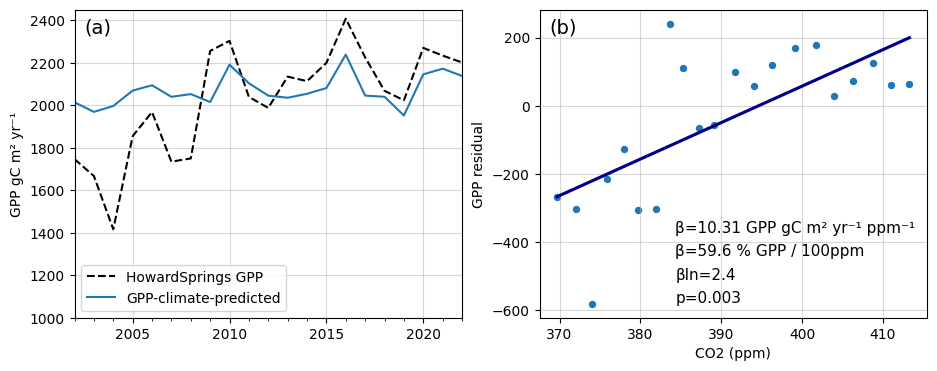

In [11]:
fig,ax = plt.subplots(1,2, figsize=(11,4))
df[f'{model_var}'].plot(ax=ax[0], label=f'{site} {model_var}', linestyle='dashed', color='k')
df[f'{model_var}_predict'].plot(ax=ax[0], label=f'{model_var}-climate-predicted')

if model_var=='GPP':
    ax[0].set_ylabel('GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹')
    ax[0].set_title(None)

if model_var=='fPAR':
    ax[0].set_ylabel('fPAR yr⁻¹')
    ax[0].set_title(None)

ax[0].grid(alpha=0.5)
ax[0].set_xlabel(None)
ax[0].legend()

sb.scatterplot(data=df, x='co2',y=f'{model_var}_residual', s=40, lw=1,ax=ax[1])
sb.regplot(data=df, x='co2',y=f'{model_var}_residual', scatter=False, color='darkblue', ax=ax[1], ci=None, robust=True)
ax[1].set_ylabel(f'{model_var} residual')
ax[1].set_xlabel('CO2 (ppm)')
# ax[1].set_ylim(-300,300)
ax[1].set_title(None)
ax[1].grid(alpha=0.5)
ax[0].set_ylim(1000,2450)

if model_var=='GPP':
    ax[1].text(.35, .275, '\u03B2={:.2f} GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'.format(beta),
                transform=ax[1].transAxes, fontsize=11);
    
    ax[1].text(.35, .2, '\u03B2={:.1f} % GPP / 100ppm'.format(beta_relative) ,
                transform=ax[1].transAxes, fontsize=11);
    ax[1].text(.35, .125, '\u03B2ln={:.1f}'.format(beta_apparent_ratio) ,
            transform=ax[1].transAxes, fontsize=11);

if model_var=='fPAR':
    ax[1].text(.35, .20, '\u03B2={:.2f} fPAR yr⁻¹ ppm⁻¹'.format(beta),
                transform=ax[1].transAxes, fontsize=11);
    
    ax[1].text(.35, .125, '\u03B2={:.1f} % fPAR / 100ppm'.format(beta_relative) ,
                transform=ax[1].transAxes, fontsize=11);
    
if pvalue<0.001:
    ax[1].text(.35, .05, 'p<0.001'.format(pvalue) ,
                transform=ax[1].transAxes, fontsize=11)
else:
    ax[1].text(.35, .05, 'p={:.3f}'.format(pvalue) ,
            transform=ax[1].transAxes, fontsize=11);

ax[0].text(0.025, 0.925, '(a)',  transform=ax[0].transAxes, fontsize=14)
ax[1].text(0.025, 0.925, '(b)',  transform=ax[1].transAxes, fontsize=14)

fig.savefig(f"/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/{site}_residual_method_{model_var}",
            bbox_inches='tight', dpi=300)

## Alternative method: Experiments holding CO2 constant

Residual between prediction when all variables kept original, and where CO2 is kept constant.

1. Model GPP using CO2, SRAD, VPD, rain, Tavg, CWD
2. Model GPP with CO2 set at average of first 3 years.
3. Find residual between GPP-predicted and GPP-CO2-constant
4. Plot residual GPP against CO2 and determine beta

### Modelling

In [12]:
# fit a model on observed data
# df = df.rolling(5, min_periods=5).mean().dropna()
x = df[['rain', 'srad', 'tavg', 'vpd','cwd', 'co2']] # original data
y = df[['GPP']]

# rescale
x_scaler = MinMaxScaler() 
x_scaled = x_scaler.fit_transform(x) 
x = pd.DataFrame(x_scaled, columns=x.columns,index=x.index)

y_scaler = MinMaxScaler() 
y_scaled = y_scaler.fit_transform(y) 
y = pd.DataFrame(y_scaled, columns=y.columns,index=y.index)

lr = PLSRegression().fit(x, y)
prediction = lr.predict(x)
prediction = y_scaler.inverse_transform(prediction)# unscale #.reshape(y.shape)

# now fit a model with CO2 held constant
constant_co2 = x['co2'].iloc[0:2].mean() #average of first 2 years
xx = x.drop('co2', axis=1)
xx['co2'] = constant_co2

lrr = PLSRegression().fit(xx, y)
# lrr = RandomForestRegressor().fit(xx, y)
pred_co2_constant = lrr.predict(xx)
pred_co2_constant = y_scaler.inverse_transform(pred_co2_constant)

# determine residual between predicted with and without co2 held constant
df['GPP_residual_co2constant'] =  prediction - pred_co2_constant

df['GPP_residual_co2constant_percent'] = df['GPP_residual_co2constant'] / np.mean(prediction[0:5])

### Plot

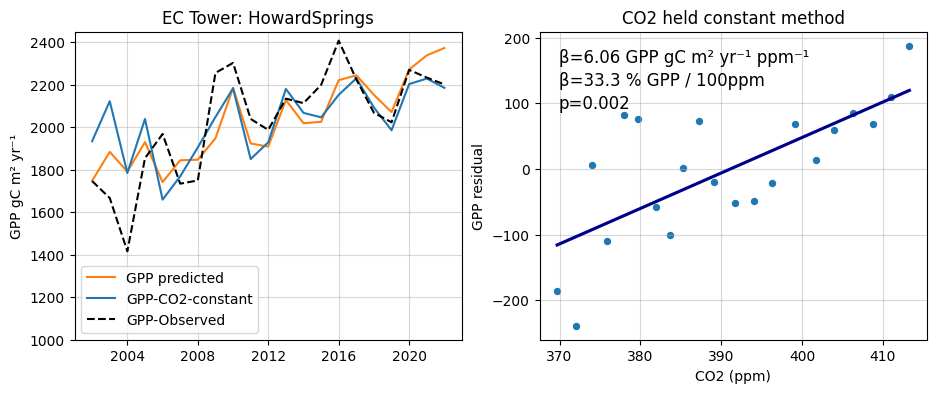

In [13]:
#find robust regression slope
regress  = theilslopes(y=df['GPP_residual_co2constant'], x=df['co2'])
beta = regress.slope 
beta_relative = theilslopes(y=df['GPP_residual_co2constant_percent'], x=df['co2']).slope * 100 * 100
pvalue = kendalltau(y=df['GPP_residual_co2constant'], x=df['co2']).pvalue


fig,ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(df.index, prediction, label='GPP predicted', color='tab:orange')
ax[0].plot(df.index, pred_co2_constant, label='GPP-CO2-constant')
ax[0].plot(df.index, df['GPP'].values, label='GPP-Observed', linestyle='dashed', color='k')

ax[0].set_ylabel('GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹')
ax[0].set_title('EC Tower: '+site)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel(None)
ax[0].legend()
ax[0].set_ylim(1000,2450)

sb.scatterplot(data=df, x='co2',y='GPP_residual_co2constant', s=40, lw=1,ax=ax[1])
sb.regplot(data=df, x='co2',y='GPP_residual_co2constant', scatter=False, color='darkblue', ax=ax[1], ci=None, robust=True)
ax[1].set_ylabel('GPP residual')
ax[1].set_xlabel('CO2 (ppm)')
# ax[1].set_ylim(-300,300)
ax[1].set_title('CO2 held constant method')
ax[1].grid(alpha=0.5)
ax[1].text(.05, .90, '\u03B2={:.2f} GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'.format(beta),
            transform=ax[1].transAxes, fontsize=12);
ax[1].text(.05, .825, '\u03B2={:.1f} % GPP / 100ppm'.format(beta_relative) ,
            transform=ax[1].transAxes, fontsize=12);

if pvalue<0.001:
    ax[1].text(.05, .75, 'p<0.001'.format(pvalue),
                transform=ax[1].transAxes, fontsize=12)
else:
    ax[1].text(.05, .75, 'p={:.3f}'.format(pvalue) ,
            transform=ax[1].transAxes, fontsize=12);